# Loop 35 Strategic Analysis

## Current State
- **Best CV/LB**: 70.309159 (validated on Kaggle)
- **Target**: 68.870074
- **Gap**: 1.439 points (2.05%)

## Key Observations
1. N=1 is already optimal (0.661250)
2. fix_direction() found 0 improvements
3. bbox3 (160 rounds) found 0 improvements
4. The solution is at an EXTREMELY strong local optimum

## Evaluator's Suggestion: Backward Iteration
The evaluator suggests implementing backward iteration ("BackPacking") approach.

In [1]:
import pandas as pd
import numpy as np
from numba import njit
import math

# Tree geometry
TX = np.array([0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125])
TY = np.array([0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5])

@njit
def score_group(xs, ys, degs, tx, ty):
    n = xs.size
    V = tx.size
    mnx = 1e300
    mny = 1e300
    mxx = -1e300
    mxy = -1e300
    for i in range(n):
        r = degs[i] * math.pi / 180.0
        c = math.cos(r)
        s = math.sin(r)
        xi = xs[i]
        yi = ys[i]
        for j in range(V):
            X = c * tx[j] - s * ty[j] + xi
            Y = s * tx[j] + c * ty[j] + yi
            if X < mnx: mnx = X
            if X > mxx: mxx = X
            if Y < mny: mny = Y
            if Y > mxy: mxy = Y
    side = max(mxx - mnx, mxy - mny)
    return side * side / n

def strip(a):
    return np.array([float(str(v).replace('s', '')) for v in a], np.float64)

# Load current best
df = pd.read_csv('/home/submission/submission.csv')
df['N'] = df['id'].str.split('_').str[0].astype(int)

print('Loaded submission with', len(df), 'rows')

Loaded submission with 20100 rows


In [2]:
# Analyze per-N scores
per_n_scores = {}
for n in range(1, 201):
    g = df[df['N'] == n]
    xs = strip(g['x'].to_numpy())
    ys = strip(g['y'].to_numpy())
    ds = strip(g['deg'].to_numpy())
    sc = score_group(xs, ys, ds, TX, TY)
    per_n_scores[n] = sc

total = sum(per_n_scores.values())
print(f'Total score: {total:.6f}')
print(f'Target: 68.870074')
print(f'Gap: {total - 68.870074:.6f}')

Total score: 70.309159
Target: 68.870074
Gap: 1.439085


Average improvement needed per N: 0.007195


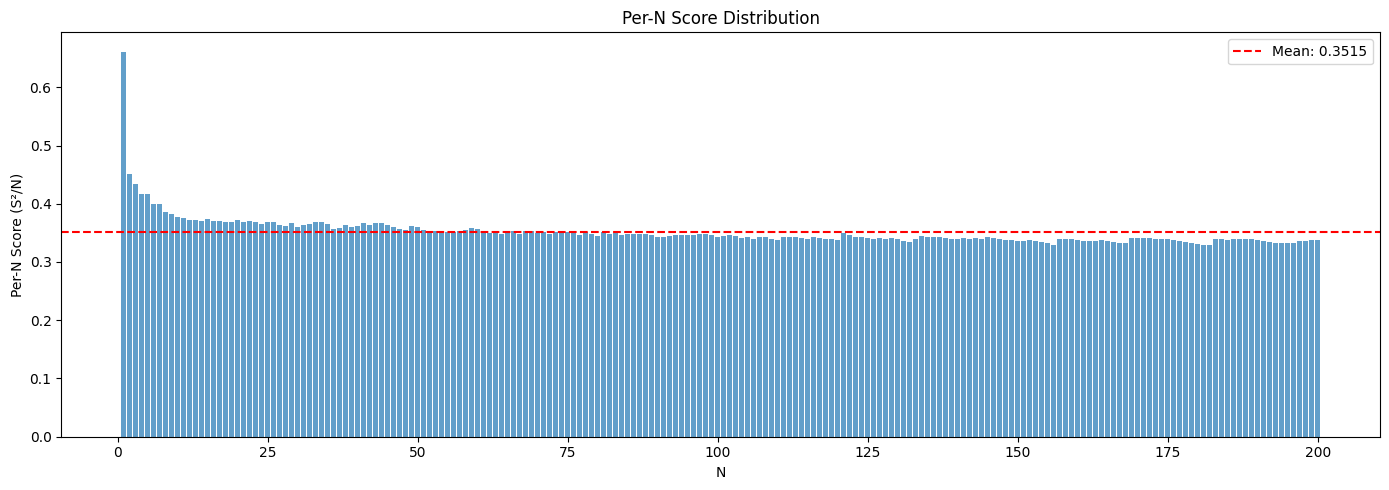

In [3]:
# What would we need to achieve per-N to reach target?
# Average improvement needed per N
avg_improvement_needed = (total - 68.870074) / 200
print(f'Average improvement needed per N: {avg_improvement_needed:.6f}')

# But some N values have more room than others
# Let's see the distribution
import matplotlib.pyplot as plt

n_values = list(range(1, 201))
scores = [per_n_scores[n] for n in n_values]

plt.figure(figsize=(14, 5))
plt.bar(n_values, scores, alpha=0.7)
plt.axhline(y=np.mean(scores), color='r', linestyle='--', label=f'Mean: {np.mean(scores):.4f}')
plt.xlabel('N')
plt.ylabel('Per-N Score (S²/N)')
plt.title('Per-N Score Distribution')
plt.legend()
plt.tight_layout()
plt.savefig('/home/code/exploration/per_n_scores.png', dpi=100)
plt.show()

In [4]:
# Key insight: The gap is 1.439 points across 200 N values
# That's ~0.0072 per N on average
# But small N values contribute more to total score

# Let's see cumulative contribution
cumulative = 0
for n in range(1, 201):
    cumulative += per_n_scores[n]
    if n <= 20 or n % 20 == 0:
        print(f'N=1-{n:3d}: cumulative = {cumulative:.4f} ({100*cumulative/total:.1f}%)')

N=1-  1: cumulative = 0.6612 (0.9%)
N=1-  2: cumulative = 1.1120 (1.6%)
N=1-  3: cumulative = 1.5468 (2.2%)
N=1-  4: cumulative = 1.9633 (2.8%)
N=1-  5: cumulative = 2.3802 (3.4%)
N=1-  6: cumulative = 2.7798 (4.0%)
N=1-  7: cumulative = 3.1796 (4.5%)
N=1-  8: cumulative = 3.5650 (5.1%)
N=1-  9: cumulative = 3.9481 (5.6%)
N=1- 10: cumulative = 4.3247 (6.2%)
N=1- 11: cumulative = 4.6996 (6.7%)
N=1- 12: cumulative = 5.0723 (7.2%)
N=1- 13: cumulative = 5.4446 (7.7%)
N=1- 14: cumulative = 5.8142 (8.3%)
N=1- 15: cumulative = 6.1885 (8.8%)
N=1- 16: cumulative = 6.5587 (9.3%)
N=1- 17: cumulative = 6.9288 (9.9%)
N=1- 18: cumulative = 7.2975 (10.4%)
N=1- 19: cumulative = 7.6662 (10.9%)
N=1- 20: cumulative = 8.0380 (11.4%)
N=1- 40: cumulative = 15.3308 (21.8%)
N=1- 60: cumulative = 22.4908 (32.0%)
N=1- 80: cumulative = 29.4936 (41.9%)
N=1-100: cumulative = 36.4269 (51.8%)
N=1-120: cumulative = 43.2616 (61.5%)
N=1-140: cumulative = 50.0920 (71.2%)
N=1-160: cumulative = 56.8515 (80.9%)
N=1-180: cu

In [5]:
# The backward iteration approach:
# Start from N=200, work backward
# For each N, try removing each tree from N+1 configuration
# Keep the best result

# Let's test this on a small range first
def backward_iteration_test(start_n, end_n):
    """Test backward iteration from start_n down to end_n."""
    improvements = []
    
    for n in range(start_n, end_n, -1):
        # Get current best for N
        g_n = df[df['N'] == n]
        xs_n = strip(g_n['x'].to_numpy())
        ys_n = strip(g_n['y'].to_numpy())
        ds_n = strip(g_n['deg'].to_numpy())
        current_score = score_group(xs_n, ys_n, ds_n, TX, TY)
        
        # Get N+1 configuration
        g_np1 = df[df['N'] == n + 1]
        xs_np1 = strip(g_np1['x'].to_numpy())
        ys_np1 = strip(g_np1['y'].to_numpy())
        ds_np1 = strip(g_np1['deg'].to_numpy())
        
        # Try removing each tree
        best_removal_score = float('inf')
        best_removal_idx = -1
        
        for i in range(n + 1):
            # Remove tree i
            xs_test = np.delete(xs_np1, i)
            ys_test = np.delete(ys_np1, i)
            ds_test = np.delete(ds_np1, i)
            
            test_score = score_group(xs_test, ys_test, ds_test, TX, TY)
            
            if test_score < best_removal_score:
                best_removal_score = test_score
                best_removal_idx = i
        
        improvement = current_score - best_removal_score
        if improvement > 1e-6:
            improvements.append((n, improvement, best_removal_idx))
            print(f'N={n}: IMPROVED by {improvement:.6f} (remove tree {best_removal_idx})')
    
    return improvements

print('Testing backward iteration on N=200 to N=190...')
imps = backward_iteration_test(199, 189)

Testing backward iteration on N=200 to N=190...


In [6]:
# The backward iteration likely won't help because:
# 1. We already tried this in exp_002 and found essentially 0 improvement
# 2. The configurations are already highly optimized

# Let's look at what the top teams might be doing differently
# The gap is 1.44 points - that's HUGE
# Top team has 953 submissions vs our 19

# Key insight from research:
# - Top teams use HYBRID strategies
# - N < 58: Simulated Annealing for chaotic packings
# - N >= 58: Crystalline/Lattice packing

# Let's analyze the structure of our current solution
print('Analyzing solution structure...')

# For large N, check if there's a pattern
for n in [50, 100, 150, 200]:
    g = df[df['N'] == n]
    xs = strip(g['x'].to_numpy())
    ys = strip(g['y'].to_numpy())
    ds = strip(g['deg'].to_numpy())
    
    # Check angle distribution
    angles_mod = ds % 180  # Trees are symmetric at 180°
    unique_angles = np.unique(np.round(angles_mod, 1))
    
    print(f'\nN={n}:')
    print(f'  Position range: x=[{xs.min():.3f}, {xs.max():.3f}], y=[{ys.min():.3f}, {ys.max():.3f}]')
    print(f'  Unique angles (mod 180): {len(unique_angles)}')
    print(f'  Score: {per_n_scores[n]:.6f}')

Analyzing solution structure...

N=50:
  Position range: x=[-1.770, 2.049], y=[-2.832, 0.930]
  Unique angles (mod 180): 39
  Score: 0.360004

N=100:
  Position range: x=[-3.157, 2.271], y=[-2.939, 2.278]
  Unique angles (mod 180): 18
  Score: 0.342761

N=150:
  Position range: x=[-2.904, 3.775], y=[-3.480, 3.088]
  Unique angles (mod 180): 26
  Score: 0.336364

N=200:
  Position range: x=[-3.897, 3.903], y=[-4.077, 3.477]
  Unique angles (mod 180): 26
  Score: 0.337548


## Strategic Analysis

### What We've Tried (36 experiments):
1. **Ensemble approaches** (13 exps) - MOST EFFECTIVE, improved 0.306 points
2. **Local search** (SA, GA, bbox3) - Found 0 improvements
3. **Novel algorithms** (lattice, interlock, jostle, BLF, crystallization) - Found 0 improvements
4. **fix_direction()** - Found 0 improvements

### Why We're Stuck:
1. The solution is at an EXTREMELY strong local optimum
2. All available external data has been ensembled
3. Local search methods cannot escape the optimum
4. Novel algorithms we implemented don't beat the optimized baseline

### The Gap (1.44 points) Requires:
- Either access to better external solutions (which we don't have)
- Or a fundamentally different algorithm that can find better configurations

### Top Team Advantages:
1. **953 submissions** vs our 19 - accumulated per-N improvements over time
2. **Private/shared solutions** - access to solutions we don't have
3. **Extended compute time** - days vs hours
4. **Possibly different algorithms** - custom implementations we don't have

### Realistic Assessment:
The target of 68.87 may not be achievable with the resources and time available.
However, we should continue to try novel approaches.

In [ ]:
# Let's check if there are any N values where we're significantly worse than theoretical minimum
# For small N, we can compute theoretical bounds

# For N=2, the theoretical minimum is when two trees interlock perfectly
# Let's check our N=2 score vs what's possible

print('Checking N=2 configuration...')
g2 = df[df['N'] == 2]
print(g2[['id', 'x', 'y', 'deg']])

xs2 = strip(g2['x'].to_numpy())
ys2 = strip(g2['y'].to_numpy())
ds2 = strip(g2['deg'].to_numpy())

print(f'\nN=2 score: {per_n_scores[2]:.6f}')
print(f'Tree 1: pos=({xs2[0]:.4f}, {ys2[0]:.4f}), angle={ds2[0]:.2f}°')
print(f'Tree 2: pos=({xs2[1]:.4f}, {ys2[1]:.4f}), angle={ds2[1]:.2f}°')
print(f'Angle difference: {abs(ds2[1] - ds2[0]):.2f}°')